# Text Models

## Objectif

Ce notebook permet de générer les jeux de données contenant les mots du corpus de texte, puis d'entrainer des modèles.

## 1. Paramètres des jeux de données

Veuillez renseigner les paramètres ci-dessous pour définir les jeux de données.

In [1]:
# Version de Python utilisée : 3.9.xx
# Import des librairies
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Define the dataset size
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

# Define the text preproc
TEXT_PREPROC = "Tfidf_default_with_stem"

# list des configuration preproc:
# 'BoW_default'   Bag of Words with default input parameters + remove html + remove numeric words.
# 'Tfidf_default' Tfidf with default input parameters + remove html + remove numeric words.
# 'Tfidf_specific' Tfidf with specific input parameter: 'min_df': 0.001 + remove html + remove numeric words.
# 'BoW_default_with_stem'  Bag of Words with default input parameters + remove html + remove numeric words + french stemming.
# 'Tfidf_default_with_stem' Tfidf with default input parameters + remove html + remove numeric words + french stemming.
# 'Tfidf_specific_with_stem' Tfidf with specific input parameter: 'min_df': 0.001 + remove html + remove numeric words + french stemming.

# Define the text model
TEXT_MODEL = "MultinomialNB"
# MultinomialNB
# SGDClassifier
# RandomForestClassifier
# GradientBoostingClassifier

## 2. Génération des jeux de données

Veuillez executer la cellule ci-dessous. Attention, l'étape de pré-processing du text peut être longue si vous avez un gros jeu de données. 

In [4]:
from sklearn.model_selection import train_test_split
from src.data import data

# Import des fichiers contenant les données
df = data.load_data("data").fillna("")

# data
features = df['designation']+" "+df['description']
target = df['prdtypecode']

# split to train, valid and test
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=123, test_size=TEST_SIZE, train_size=TRAIN_SIZE)

# definition du nom du dataframe (mandatory)
X_train.name = 'X_train'
X_test.name = 'X_test'

## Pre-processing & vectorisation pipelines

In [5]:
from src.data.vectorization_pipeline import BagOfWordsDefault
from src.data.vectorization_pipeline import TfidfDefault
from src.data.vectorization_pipeline import TfidfV1
from src.data.vectorization_pipeline import BOW_Stemming
from src.data.vectorization_pipeline import TfidfStemming
from src.data.vectorization_pipeline import TfidfStemmingV1


text_preprocessing = {'BoW_default':BagOfWordsDefault(),
                      'Tfidf_default':TfidfDefault(),
                      'Tfidf_specific':TfidfV1(),
                      'BoW_default_with_stem':BOW_Stemming(),
                      'Tfidf_default_with_stem':TfidfStemming(),
                      'Tfidf_specific_with_stem':TfidfStemmingV1()}

text_preproc = text_preprocessing[TEXT_PREPROC]

INFO:textpipeline:class:BagOfWordsDefault
INFO:textpipeline:class:TfidfDefault
INFO:textpipeline:class:TfidfV1
INFO:textpipeline:class:BOW_Stemming
INFO:textpipeline:class:TfidfStemming
INFO:textpipeline:class:TfidfStemmingV1


In [6]:
import pickle
from src.data.text_preproc_pipeline import TextPreprocess


_preproc = TextPreprocess(text_preproc)
_preproc.fit(X_train)

X_train_preproc = _preproc.transform(X_train)
X_test_preproc = _preproc.transform(X_test)

filenames = {}
filenames['feat_train_filename'] = _preproc.save(X_train_preproc, "data/training/X_train_")
filenames['feat_test_filename'] = _preproc.save(X_test_preproc, "data/training/X_test_")

filenames['target_train_filename'] = _preproc.save(y_train, "data/training/y_train")
filenames['target_test_filename'] = _preproc.save(y_test, "data/training/y_test")
filenames['voc_filename'] = _preproc.save_voc("data/training/voc_")



file_name = f"data/training/{TEXT_PREPROC}_filenames.pkl"
with open(file_name,'wb') as fp:
    pickle.dump(filenames, fp)


INFO:textpipeline:TextPreprocess.fit X_train 225.96 seconds
INFO:textpipeline:TextPreprocess.transform X_train 171.64 seconds
INFO:textpipeline:TextPreprocess.transform X_test 39.96 seconds
INFO:textpipeline:TextPreprocess.save data/training/X_train__TfidfStemming.pkl 0.06 seconds
INFO:textpipeline:TextPreprocess.save data/training/X_test__TfidfStemming.pkl 0.01 seconds
INFO:textpipeline:TextPreprocess.save data/training/y_train_TfidfStemming.pkl 0.00 seconds
INFO:textpipeline:TextPreprocess.save data/training/y_test_TfidfStemming.pkl 0.01 seconds
INFO:textpipeline:TextPreprocess.save_voc size 85230
INFO:textpipeline:TextPreprocess.save_voc data/training/voc__TfidfStemming.pkl


Attention, il est maintenant recommandé de redémarrer le kernel Jupyter pour vider la RAM utilisée par la cellule ci-dessus.

Relancer la première cellule avec la variable TEXT_PREPROC et TEXT_MODEL

## 3. Entrainement du modèle

Instanciez votre modèle dans la cellule ci-dessous, puis executer les cellules à la suite.

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

text_models = {'MultinomialNB':MultinomialNB(alpha=0.001),
               'SGDClassifier':SGDClassifier(loss='modified_huber', max_iter=5, random_state=0, shuffle=True, n_jobs=),
               'RandomForestClassifier':RandomForestClassifier(),
               'GradientBoostingClassifier':GradientBoostingClassifier()}

In [34]:
import pickle

# load  
filenames = pickle.load(open(f"data/training/{TEXT_PREPROC}_filenames.pkl", "rb"))

X_train = pickle.load(open(filenames['feat_train_filename'] , "rb"))
y_train = pickle.load(open(filenames['target_train_filename'], "rb"))

X_test = pickle.load(open(filenames['feat_test_filename'], "rb"))
y_test = pickle.load(open(filenames['target_test_filename'], "rb"))


In [35]:
import numpy as np
print(y_train.shape)
y_train = np.asarray(y_train.todense().reshape(-1, 1))
print(y_train.shape)
print(type(y_train))

(1, 67932)
(67932, 1)
<class 'numpy.ndarray'>


In [36]:
print(y_test.shape)
y_test = np.asarray(y_test.todense().reshape(-1, 1))
print(y_test.shape)
print(type(y_test))

(1, 16984)
(16984, 1)
<class 'numpy.ndarray'>


In [37]:
model = text_models[TEXT_MODEL]
model.fit(X_train, y_train)

d:\Agnoli\Datascientest\Projet\Fev23_BDS_Rakuten\.conda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.001)

In [38]:
print('Train accuracy: ', model.score(X_train, y_train))
print('Test accuracy: ', model.score(X_test, y_test))

Train accuracy:  0.914620502855797
Test accuracy:  0.7647786151672162


In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          10       0.55      0.28      0.38       601
          40       0.64      0.47      0.55       475
          50       0.77      0.81      0.79       341
          60       0.94      0.80      0.87       176
        1140       0.67      0.74      0.71       552
        1160       0.93      0.90      0.91       791
        1180       0.66      0.57      0.61       139
        1280       0.57      0.57      0.57       944
        1281       0.49      0.40      0.44       415
        1300       0.81      0.95      0.88      1006
        1301       0.95      0.92      0.94       154
        1302       0.80      0.76      0.78       505
        1320       0.80      0.74      0.77       635
        1560       0.74      0.78      0.76       967
        1920       0.88      0.89      0.88       866
        1940       0.91      0.88      0.89       175
        2060       0.70      0.77      0.73      1060
        2220       0.91    

In [61]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
                   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [45]:
np.unique(y_train)

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905], dtype=int64)

Confusion matrix, without normalization
[[ 171   17    0    0    6    3    4   20   19    7    0    3    6    4
     3    2    9    1  109   84    3    9    4    5    2   97   13]
 [  11  225   34    2   31   10    3   21   25   11    0    1    2    0
     0    0    4    1   15   15   25    1    0    4    3   15   16]
 [   0   14  275    6    6    0    0    0    1    6    0    1    1    0
     0    0    1    0    0    0   28    1    0    0    1    0    0]
 [   0    7    7  141    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0   16    0    0    0    0    1    3]
 [   2   15    0    0  411    7    9   33   10    2    0    2    2    3
     0    2    4    0   13   19    4    6    0    2    0    4    2]
 [   3    6    0    0   12  708    4    7    9    2    0    1    1    1
     0    1    1    0   13    9    8    1    0    1    0    2    1]
 [   4    3    2    0   12    2   79    5    9    0    0    1    3    2
     0    0    2    0    1    4    1    0    0  

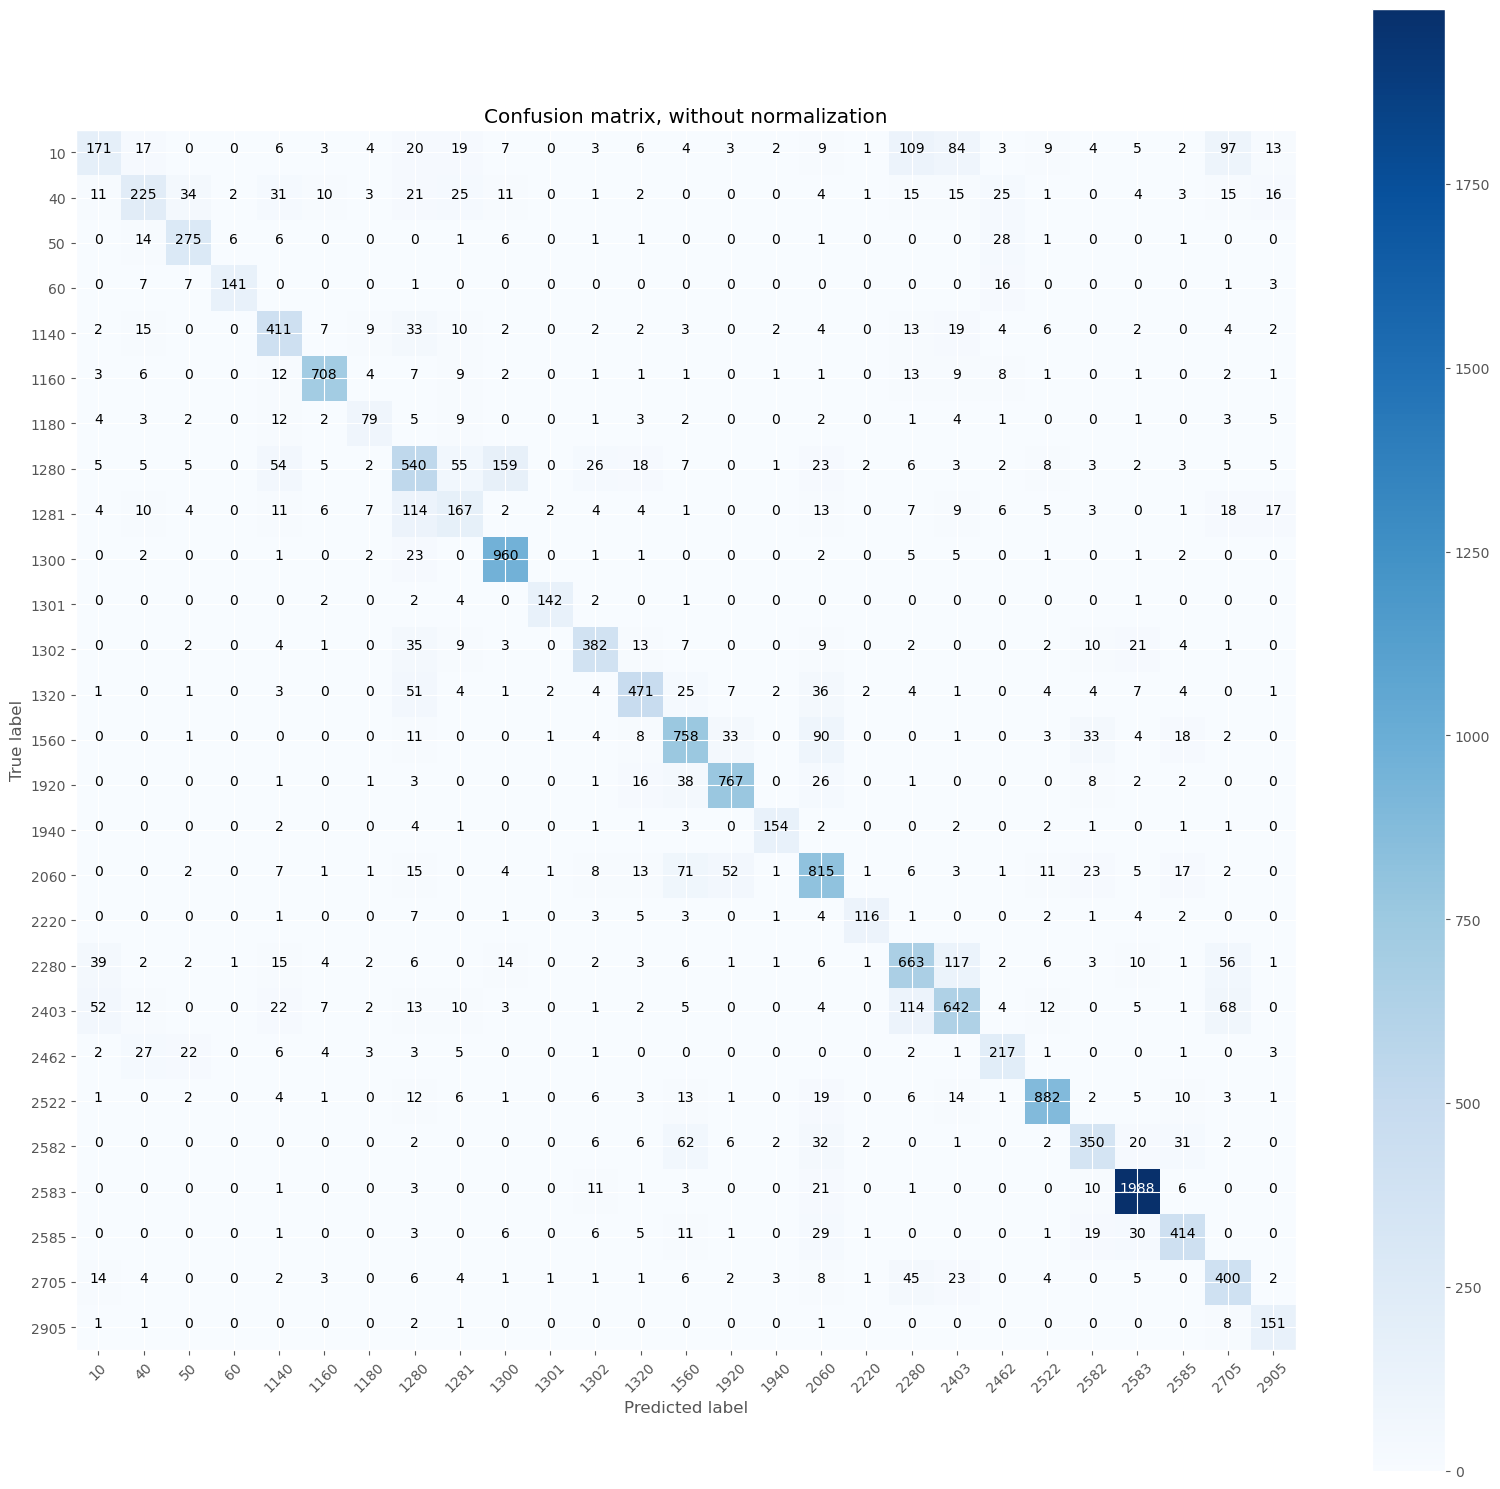

In [62]:
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(16, 15))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train),
                      title='Confusion matrix, without normalization')